In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
gc.enable()
import time
import warnings
warnings.filterwarnings

<function warnings.filterwarnings>

In [0]:
train_identity= pd.read_csv("train_identity.csv", index_col='TransactionID')
train_transaction= pd.read_csv("train_transaction.csv", index_col='TransactionID')
test_identity= pd.read_csv("test_identity.csv", index_col='TransactionID')
test_transaction = pd.read_csv("test_transaction.csv", index_col='TransactionID')

In [5]:
train_transaction.head()


,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


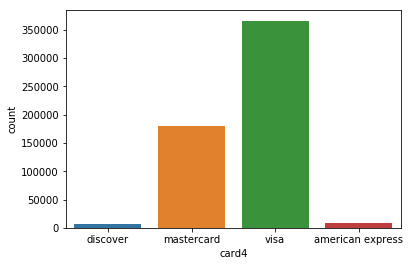

In [6]:
sns.countplot(train_transaction['card4']) 


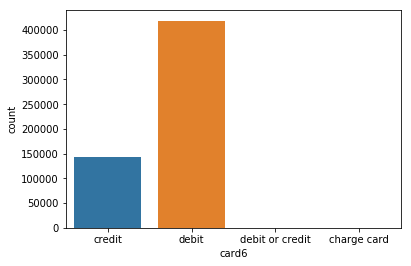

In [7]:
sns.countplot(train_transaction['card6'])

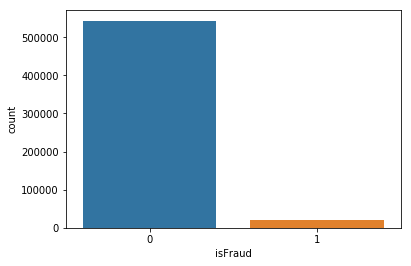

In [8]:
sns.countplot(train_transaction['isFraud'])

In [9]:
print(np.mean(train_transaction.loc[train_transaction["isFraud"]==0]['TransactionAmt']))
print(np.std(train_transaction.loc[train_transaction["isFraud"]==0]['TransactionAmt']))
print(np.mean(train_transaction.loc[train_transaction["isFraud"]==1]['TransactionAmt']))
print(np.std(train_transaction.loc[train_transaction["isFraud"]==1]['TransactionAmt']))

134.13904302435574
238.42015533284953
147.78174007682787
227.7145506193417


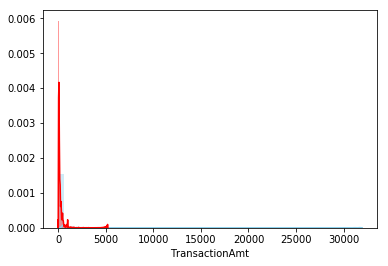

In [10]:
sns.distplot( train_transaction.loc[train_transaction["isFraud"]==0]['TransactionAmt'] , color="skyblue")
sns.distplot( train_transaction.loc[train_transaction["isFraud"]==1]['TransactionAmt'] , color="red")


In [0]:
train = pd.merge(train_identity, train_transaction, on = 'TransactionID', how = 'left')
test = pd.merge(test_identity, test_transaction, on = 'TransactionID', how = 'left')

In [12]:
train.info()
train.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 144233 entries, 2987004 to 3577534
Columns: 433 entries, id_01 to V339
dtypes: float64(402), object(31)
memory usage: 477.6+ MB


,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows,...,1.0,1.0,1.0,1.0,1.0,1.0,166.215393,166.215393,166.215393,90.327904,90.327904,31.841299,90.327904,90.327904,90.327904,90.327904,0.0,0.0,0.0,75.887497,75.887497,75.887497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS,...,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
del train_identity, train_transaction, test_identity, test_transaction



In [0]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            print("min for this col: ",mn)
            print("max for this col: ",mx)
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [15]:
train, NAlist = reduce_mem_usage(train)
print(NAlist)

Memory usage of properties dataframe is : 477.57814025878906  MB
******************************
Column:  id_01
dtype before:  float64
min for this col:  -100.0
max for this col:  0.0
dtype after:  int8
******************************
******************************
Column:  id_02
dtype before:  float64
min for this col:  1.0
max for this col:  999595.0
dtype after:  uint32
******************************
******************************
Column:  id_03
dtype before:  float64
min for this col:  -13.0
max for this col:  10.0
dtype after:  int8
******************************
******************************
Column:  id_04
dtype before:  float64
min for this col:  -28.0
max for this col:  0.0
dtype after:  int8
******************************
******************************
Column:  id_05
dtype before:  float64
min for this col:  -72.0
max for this col:  52.0
dtype after:  int8
******************************
******************************
Column:  id_06
dtype before:  float64
min for this col:  -100

In [16]:
print(train.shape,test.shape)


(144233, 433) (141907, 432)


In [17]:
train.isna().any()

id_01    False
id_02    False
id_03    False
id_04    False
id_05    False
id_06    False
id_07    False
id_08    False
id_09    False
id_10    False
id_11    False
id_12    False
id_13    False
id_14    False
id_15     True
id_16     True
id_17    False
id_18    False
id_19    False
id_20    False
id_21    False
id_22    False
id_23     True
id_24    False
id_25    False
id_26    False
id_27     True
id_28     True
id_29     True
id_30     True
         ...  
V310     False
V311     False
V312     False
V313     False
V314     False
V315     False
V316     False
V317     False
V318     False
V319     False
V320     False
V321     False
V322     False
V323     False
V324     False
V325     False
V326     False
V327     False
V328     False
V329     False
V330     False
V331     False
V332     False
V333     False
V334     False
V335     False
V336     False
V337     False
V338     False
V339     False
Length: 433, dtype: bool

In [18]:
miss_data = pd.isnull(train).sum().sort_values(ascending=False)
miss_per = (miss_data/len(train))*100
missing_data = pd.concat(objs = [miss_data, miss_per], keys = ['Columns','Missing values percentage'], axis = 1)
def delnullcol(dt):
    nullcol = [col for col in dt.columns if dt[col].isnull().sum()/dt.shape[0] >= 0.9]
    return nullcol
null_cols = delnullcol(train)
print(str(len(null_cols)))

23


In [19]:
train.dtypes

id_01       int8
id_02     uint32
id_03       int8
id_04       int8
id_05       int8
id_06       int8
id_07       int8
id_08       int8
id_09       int8
id_10       int8
id_11    float32
id_12     object
id_13      uint8
id_14      int16
id_15     object
id_16     object
id_17      uint8
id_18      uint8
id_19     uint16
id_20     uint16
id_21     uint16
id_22      uint8
id_23     object
id_24      uint8
id_25     uint16
id_26      uint8
id_27     object
id_28     object
id_29     object
id_30     object
          ...   
V310     float32
V311     float32
V312     float32
V313     float32
V314     float32
V315     float32
V316     float32
V317     float32
V318     float32
V319     float32
V320     float32
V321     float32
V322      uint16
V323      uint16
V324      uint16
V325       uint8
V326       uint8
V327       uint8
V328       uint8
V329       uint8
V330       uint8
V331     float32
V332     float32
V333     float32
V334     float32
V335     float32
V336     float32
V337     float

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Imputer

train = pd.get_dummies(train)
X_train = train.drop('isFraud', axis=1)
X_train = X_train.fillna(0)
y_train = train['isFraud']

In [21]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(regressor, X_train, y_train[:np.shape(X_train)[0]], cv=3, verbose=3)
score.mean()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .................................... , score=0.918, total= 3.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[CV] .................................... , score=0.927, total= 2.5min
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.0min remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[CV] .................................... , score=0.806, total= 5.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min finished


0.8838887240699838